In [173]:
import pandas as pd
import numpy as np

In [174]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [175]:
from sqlalchemy import create_engine

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [177]:
from scipy.sparse import csr_matrix

In [178]:
from sklearn.externals import joblib

In [179]:
import datetime as dt

In [180]:
import pickle

In [181]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter('ignore')

# Data Pre-Processing

In [182]:
engine = create_engine("sqlite:///../db/twitter_db.sqlite")
conn = engine.connect()

In [183]:
tweets_df = pd.read_sql("SELECT * FROM tweet_data", conn)

In [184]:
tweets_df.head(2)

,id,created_at,created_at_time,created_at_date,created_at_datetime,tweet_id,tweet_id_str,full_text,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user_id,user_id_str,user_name,user_screen_name,retweet_count,favorite_count
0,1,Wed Jul 31 22:21:23 +0000 2019,22:21:23.000000,2019-07-31,2019-07-31 22:21:23.000000,1156691352983412737,1156691352983412737,"Here's the deal, President Trump inherited the economy from the Obama-Biden Administration. And ...",NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,938,4134
1,2,Wed Jul 31 21:28:00 +0000 2019,21:28:00.000000,2019-07-31,2019-07-31 21:28:00.000000,1156677917469896704,1156677917469896704,I’ve got some exciting news: I am now on Snapchat! Subscribe to get a behind-the-scenes look at ...,NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,173,790


In [185]:
len(tweets_df)

43421

In [186]:
tweets_df["created_at_datetime"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strptime(x,
                                                                "%Y-%m-%d %H:%M:%S.%f"))

In [187]:
tweets_df = tweets_df.loc[tweets_df["created_at_datetime"] < dt.datetime(2019,8,15), :].reset_index(drop=True)

In [188]:
len(tweets_df)

40678

In [192]:
# Below, the number of candidates was reduced to reduce mdoel file size (6 to 5)

In [193]:
grouped_df = tweets_df.groupby(tweets_df['user_name']).median()
grouped_df = grouped_df[['retweet_count']].sort_values('retweet_count', ascending = False).iloc[:6]
# grouped_df.sort_values('retweet_count', ascendingh = False)
grouped_df
top_candidates =[]
for i, r in grouped_df.iterrows():
    top_candidates.append(i)
# Remove Eric Swalwell from list (dropped out)
top_candidates.pop(3)
top_candidates

['Donald J. Trump',
 'Bernie Sanders',
 'Kamala Harris',
 'Elizabeth Warren',
 'Joe Biden']

In [255]:
with open('top_candidates.pkl', 'wb') as f:
   pickle.dump(top_candidates, f)

In [194]:
tweets_df = tweets_df.loc[tweets_df['user_name'].isin(top_candidates), :].reset_index(drop=True)

In [195]:
len(tweets_df)

9585

In [196]:
tweets_df["day"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%A"))
tweets_df["hour"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%H"))
tweets_df["month"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%B"))

In [197]:
tweets_df.drop(columns = ["created_at", "created_at_time", "created_at_date","created_at_datetime",
                    "tweet_id", "tweet_id_str", "in_reply_to_status_id",
                    "in_reply_to_status_id_str", "in_reply_to_user_id",
                    "in_reply_to_user_id_str", "in_reply_to_screen_name",
                    "user_id_str", "user_id", "user_screen_name", "id"], inplace = True)

In [198]:
tweets_df = tweets_df[["user_name", "month", "day", "hour", "retweet_count", "favorite_count", "full_text"]]

In [199]:
tweets_df.head(2)

,user_name,month,day,hour,retweet_count,favorite_count,full_text
0,Joe Biden,July,Wednesday,22,938,4134,"Here's the deal, President Trump inherited the economy from the Obama-Biden Administration. And ..."
1,Joe Biden,July,Wednesday,21,173,790,I’ve got some exciting news: I am now on Snapchat! Subscribe to get a behind-the-scenes look at ...


In [200]:
len(tweets_df.groupby(tweets_df["user_name"]).count())

5

In [201]:
X_count_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_count_df = pd.get_dummies(X_count_df, columns = ["month", "day", "hour"])

In [202]:
X_count_df.head(2)

,full_text,retweet_count,favorite_count,month_April,month_August,month_December,month_February,month_January,month_July,month_June,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,"Here's the deal, President Trump inherited the economy from the Obama-Biden Administration. And ...",938,4134,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,I’ve got some exciting news: I am now on Snapchat! Subscribe to get a behind-the-scenes look at ...,173,790,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [203]:
import nltk
import re
import string
pd.set_option('display.max_colwidth', 100) # To extend column width

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

In [204]:
def clean_text(text):
    text = text.replace('&amp;', '&')
    text = text.replace('\n', ' ')
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Bag of Words

# Count Vectorizer

In [205]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer
count_vect = CountVectorizer(analyzer=clean_text)
X_count_vect = count_vect.fit_transform(X_count_df['full_text'])

In [206]:
X_count_df.drop(columns = ['full_text'], inplace = True)

In [207]:
X_count_df = pd.concat([X_count_df, pd.DataFrame(X_count_vect.toarray(), columns=count_vect.get_feature_names())], axis=1)

In [208]:
X_count_df.shape

(9585, 18591)

In [209]:
rf_columns = X_count_df.columns

In [210]:
rf_columns

Index(['retweet_count', 'favorite_count', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March',
       ...
       'شده', 'فساد', 'فقط', 'مدتهاست', 'مردم', 'موجب', 'هستند', 'چهلسالشکست',
       'که', '۴۰'],
      dtype='object', length=18591)

In [211]:
rf_columns_list = list(rf_columns)

In [212]:
len(rf_columns)

18591

In [213]:
with open('rf_columns.pkl', 'wb') as f:
   pickle.dump(rf_columns_list, f)

In [214]:
data_y = tweets_df.values
data_x = X_count_df.values
X_count = data_x[:, 0:]
y_count = data_y[:,0]

In [215]:
X_count

array([[  938,  4134,     0, ...,     0,     0,     0],
       [  173,   790,     0, ...,     0,     0,     0],
       [  712,  4376,     0, ...,     0,     0,     0],
       ...,
       [  741, 20234,     0, ...,     0,     0,     0],
       [18289, 68718,     0, ...,     0,     0,     0],
       [   11,    74,     0, ...,     0,     0,     0]], dtype=int64)

In [216]:
X_count.shape

(9585, 18591)

In [217]:
X_count_sparse = csr_matrix(X_count)

In [218]:
X_count_sparse

<9585x18591 sparse matrix of type '<class 'numpy.int64'>'
	with 215151 stored elements in Compressed Sparse Row format>

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
from sklearn.preprocessing import MaxAbsScaler

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
from matplotlib.legend_handler import HandlerLine2D

In [39]:
# from keras.utils import to_categorical

## Train-Test-Split/Label-Encoding (Grid Search)

In [219]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_count_sparse, y_count, random_state=42,
                                                               train_size = 0.9,
                                                               shuffle = True)

In [220]:
X_scaler_cv = MaxAbsScaler().fit(X_train_cv)

In [221]:
scaler_filename = "rf_scaler.save"
joblib.dump(X_scaler_cv, scaler_filename) 

['rf_scaler.save']

In [222]:
X_train_scaled_cv = X_scaler_cv.transform(X_train_cv)
X_test_scaled_cv = X_scaler_cv.transform(X_test_cv)

In [223]:
# Step 1: Label-encode data set
label_encoder_cv = LabelEncoder()
label_encoder_cv.fit(y_train_cv)

encoded_y_train_cv = label_encoder_cv.transform(y_train_cv)
encoded_y_test_cv = label_encoder_cv.transform(y_test_cv)

In [224]:
encoded_y_train_cv

array([1, 3, 1, ..., 0, 3, 1])

In [225]:
encoded_y_train_cv = encoded_y_train_cv.reshape(-1, 1)
encoded_y_test_cv = encoded_y_test_cv.reshape(-1, 1)

In [226]:
encoded_y_train_cv

array([[1],
       [3],
       [1],
       ...,
       [0],
       [3],
       [1]])

In [227]:
label_encoder_cv.classes_

array(['Bernie Sanders', 'Donald J. Trump', 'Elizabeth Warren',
       'Joe Biden', 'Kamala Harris'], dtype=object)

In [228]:
np.save('rf_classes.npy', label_encoder_cv.classes_)

## Train-Test-Split/Label Encoding (In-Depth Parameter Tuning)

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X_count_sparse, y_count, random_state=42)

In [230]:
X_scaler = MaxAbsScaler().fit(X_train)

In [231]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [232]:
X_train_scaled.shape

(7188, 18591)

In [233]:
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [234]:
encoded_y_train = encoded_y_train.reshape(-1, 1)
encoded_y_test = encoded_y_test.reshape(-1, 1)

## N_estimators (Count Vectorizer)

In [235]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

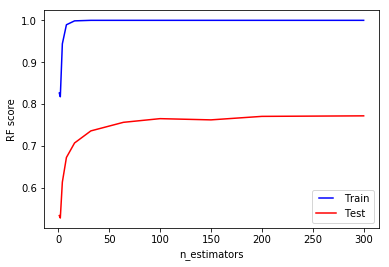

In [236]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# Best ~ 200 (50 - 250)

## Max-Depth (Count Vectorizer)

In [237]:
max_depths = list(np.linspace(1, 90, 90, endpoint=True))

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

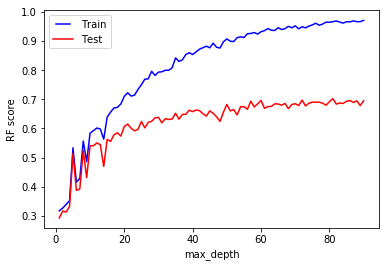

In [238]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depth')
plt.show()

In [ ]:
# Best ~ 20 (5 - 15)

## Min_samples_split (Count Vectorizer)

In [239]:
min_samples_splits = list(np.linspace(0.1, 1.0, 10, endpoint=True))

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)
    
    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

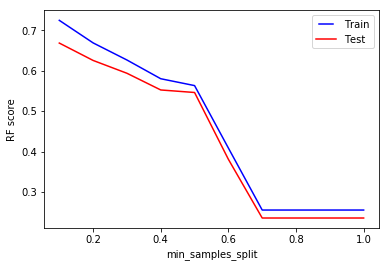

In [240]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_split')
plt.show()

In [ ]:
#Best ~ 2

## Min_samples_leaf (Count Vectorizer)

In [241]:
min_samples_leafs = list(np.linspace(.01, 0.5, 20, endpoint = True))

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

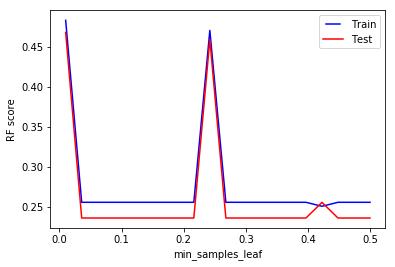

In [242]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_leaf')
plt.show()

## Max_features (Count Vectorizer)

In [243]:
max_features_list = list(range(1, 3000, 100))

train_results = []
test_results = []
for max_features in max_features_list:
    rf = RandomForestClassifier(max_features=max_features, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)
    
    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

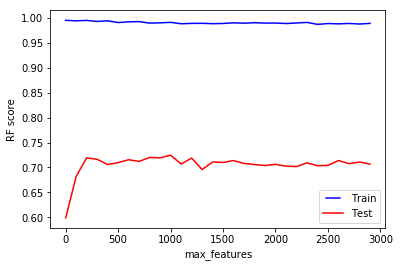

In [244]:
line1, = plt.plot(max_features_list, train_results, 'b', label="Train")
line2, = plt.plot(max_features_list, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_features')
plt.show()

## In-Depth Parameter Tuning Scoring (Count Vectorizer)

In [245]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 150)
rf = rf.fit(X_train_scaled, encoded_y_train)
rf.score(X_test_scaled, encoded_y_test)

0.6433041301627034

## GridSearch (Count Vectorizer)

In [246]:
max_depth_gs = list(range(5, 16, 2))
max_depth_gs.append(None)
max_depth_gs

[5, 7, 9, 11, 13, 15, None]

In [248]:
rf = RandomForestClassifier()
param = {'n_estimators': list(range(10, 151, 14)),
        'max_depth': max_depth_gs,
         'max_features': list(range(100, 301, 20))
        }

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, verbose = 3)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_train_scaled_cv, encoded_y_train_cv)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

Fitting 5 folds for each of 847 candidates, totalling 4235 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 4235 out of 4235 | elapsed: 48.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
746,36.397889,0.285347,0.215225,0.020248,None,120,136,"{'max_depth': None, 'max_features': 120, 'n_estimators': 136}",0.768384,0.785756,...,0.772664,0.009812,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
734,32.844588,0.719144,0.206647,0.016658,None,100,122,"{'max_depth': None, 'max_features': 100, 'n_estimators': 122}",0.772438,0.774754,...,0.769650,0.005577,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
735,36.460920,1.119046,0.226993,0.013360,None,100,136,"{'max_depth': None, 'max_features': 100, 'n_estimators': 136}",0.760857,0.782860,...,0.769534,0.009859,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
736,39.992278,1.082836,0.253522,0.017325,None,100,150,"{'max_depth': None, 'max_features': 100, 'n_estimators': 150}",0.761436,0.774175,...,0.768607,0.006829,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
732,24.799298,0.546369,0.158377,0.019466,None,100,94,"{'max_depth': None, 'max_features': 100, 'n_estimators': 94}",0.760278,0.778228,...,0.768259,0.007299,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [249]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=136, max_depth=None, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 120)
rf_model = rf_model.fit(X_train_scaled_cv, encoded_y_train_cv)
rf_model.score(X_test_scaled_cv, encoded_y_test_cv)

0.7883211678832117

In [250]:
filename = "rf_model.sav"

In [254]:
with open(filename, 'wb') as f:
   pickle.dump(rf_model, f)

In [252]:
rf_model.feature_importances_

array([8.35199148e-02, 7.76458902e-02, 2.17507540e-03, ...,
       0.00000000e+00, 0.00000000e+00, 1.80921598e-06])

In [253]:
sorted(zip(rf_model.feature_importances_, rf_columns_list), reverse=True)

[(0.08351991481284712, 'retweet_count'),
 (0.07764589021852175, 'favorite_count'),
 (0.00557769571189094, 'great'),
 (0.004920637033092918, 'plan'),
 (0.004705695531516156, 'fight'),
 (0.004041766522086816, 'democrat'),
 (0.003944657699143879, 'must'),
 (0.003502780565570889, 'medicare'),
 (0.0034692310671229176, 'month_January'),
 (0.0033663087989394664, 'big'),
 (0.003332847640774175, 'need'),
 (0.0032226914268346477, 'hour_12'),
 (0.003079302739450354, 'hour_11'),
 (0.0028662361288259823, 'woman'),
 (0.0027804289280391734, 'president'),
 (0.0027387657362832347, 'people'),
 (0.002710011950795766, 'health'),
 (0.0026052937841952216, 'month_June'),
 (0.002589272112554968, 'month_July'),
 (0.00255081173665408, ''),
 (0.0025377062502487404, 'trump'),
 (0.002508620525009812, 'right'),
 (0.002482448067991084, 'american'),
 (0.002478301007778614, 'family'),
 (0.002440462663741741, 'nation'),
 (0.0024310957076374043, 'grateful'),
 (0.002431055155367699, 'act'),
 (0.0024087250154510857, 'day_

# TF-IDF Vectorizer

In [97]:
X_tdidf_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_tdidf_df = pd.get_dummies(X_tdidf_df, columns = ["month", "day", "hour"])

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf_vect = tfidf_vect.fit_transform(X_tdidf_df['full_text'])

In [99]:
X_tdidf_df.drop(columns = ['full_text'], inplace = True)

In [100]:
X_tdidf_df = pd.concat([X_tdidf_df, pd.DataFrame(X_tfidf_vect.toarray(), columns=tfidf_vect.get_feature_names())], axis=1)

In [101]:
X_tdidf_df.shape

(10520, 20445)

In [102]:
data_y_idf = tweets_df.values
data_x_idf = X_tdidf_df.values
X_count_idf = data_x_idf[:, 0:]
y_count_idf = data_y_idf[:,0]

In [103]:
X_count_idf

array([[9.3800e+02, 4.1340e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7300e+02, 7.9000e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.1200e+02, 4.3760e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [7.4100e+02, 2.0234e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.8289e+04, 6.8718e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.1000e+01, 7.4000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [104]:
X_count_idf.shape

(10520, 20445)

In [105]:
y_count_idf

array(['Joe Biden', 'Joe Biden', 'Joe Biden', ..., 'Elizabeth Warren',
       'Elizabeth Warren', 'Elizabeth Warren'], dtype=object)

In [106]:
X_count_idf_sparse = csr_matrix(X_count_idf)

## Train-Test-Split/Label-Encoding (Grid Search)


In [107]:
X_train_idf_cv, X_test_idf_cv, y_train_idf_cv, y_test_idf_cv = train_test_split(X_count_idf_sparse, 
                                                                y_count_idf, random_state=42,
                                                               train_size = 0.9,
                                                               shuffle = True)

In [108]:
X_scaler_idf_cv = MaxAbsScaler().fit(X_train_idf_cv)

In [110]:
X_train_scaled_idf_cv = X_scaler_idf_cv.transform(X_train_idf_cv)
X_test_scaled_idf_cv = X_scaler_idf_cv.transform(X_test_idf_cv)

In [76]:
min_samples_leafs = list(np.linspace(.01, 0.5, 20, endpoint = True))

In [77]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled, encoded_y_train)

    train_results.append(rf.score(X_train_scaled, encoded_y_train))
    test_results.append(rf.score(X_test_scaled, encoded_y_test))

In [111]:
# Step 1: Label-encode data set
label_encoder_idf_cv = LabelEncoder()
label_encoder_idf_cv.fit(y_train_idf_cv)

encoded_y_train_idf_cv = label_encoder_idf_cv.transform(y_train_idf_cv)
encoded_y_test_idf_cv = label_encoder_idf_cv.transform(y_test_idf_cv)

In [112]:
encoded_y_train_idf_cv = encoded_y_train_idf_cv.reshape(-1, 1)
encoded_y_test_idf_cv = encoded_y_test_idf_cv.reshape(-1, 1)

# TF-IDF Vectorizer

## Train-Test-Split/Label-Encoding (In-Depth Parameter Tuning)

In [113]:
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(X_count_idf_sparse, y_count_idf, random_state=42,
                                                                   shuffle = True)

In [114]:
X_scaler_idf = MaxAbsScaler().fit(X_train_idf)

In [115]:
X_train_scaled_idf = X_scaler_idf.transform(X_train_idf)
X_test_scaled_idf = X_scaler_idf.transform(X_test_idf)

In [116]:
# Step 1: Label-encode data set
label_encoder_idf = LabelEncoder()
label_encoder_idf.fit(y_train_idf)

encoded_y_train_idf = label_encoder_idf.transform(y_train_idf)
encoded_y_test_idf = label_encoder_idf.transform(y_test_idf)

In [117]:
encoded_y_train_idf = encoded_y_train_idf.reshape(-1, 1)
encoded_y_test_idf = encoded_y_test_idf.reshape(-1, 1)

## In-Depth Parameter Tuning

## N-Estimators (TF-IDF Vectorizer)

In [118]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

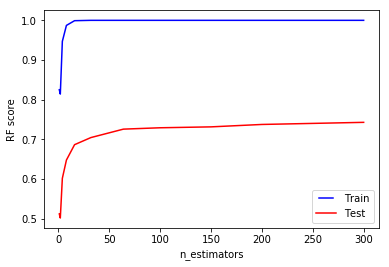

In [119]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('n_estimators')
plt.show()

In [120]:
# Best: n-estimators=150 (10 - 250)

## Max-Depth (TF-IDF Vectorizer)

In [121]:
max_depths = list(np.linspace(1, 90, 90, endpoint=True))

In [122]:
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

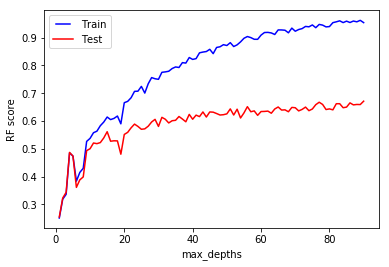

In [123]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depths')
plt.show()

In [124]:
#Best: max_depth= 8 (2-12)

## Min_samples_split (TF-IDF Vectorizer)

In [125]:
min_samples_splits = list(np.linspace(0.1, 1.0, 10, endpoint=True))

In [126]:
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

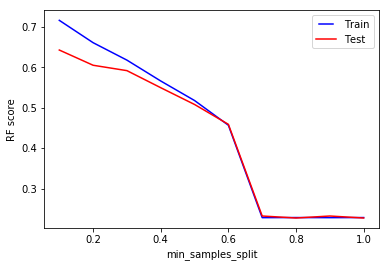

In [127]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_split')
plt.show()

In [128]:
# Best: min_samples_split=2

## Min_samples_leaf (TF-IDF Vectorizer)

In [129]:
min_samples_leafs = list(np.linspace(.01, 0.5, 20, endpoint = True))

In [130]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

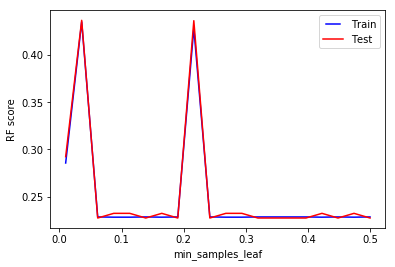

In [131]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_leaf')
plt.show()

In [132]:
#Best: min_samples_leaf = 1

## Max_Features (TF-IDF Vectorizer)

In [133]:
max_features_list = list(range(1, 3000, 100))

In [134]:
train_results = []
test_results = []
for max_features in max_features_list:
    rf = RandomForestClassifier(max_features=max_features, n_jobs=-1)
    rf.fit(X_train_scaled_idf, encoded_y_train_idf)
    
    train_results.append(rf.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(rf.score(X_test_scaled_idf, encoded_y_test_idf))

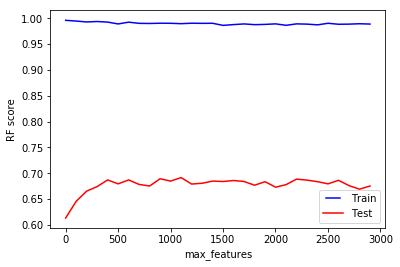

In [135]:
line1, = plt.plot(max_features_list, train_results, 'b', label="Train")
line2, = plt.plot(max_features_list, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_features')
plt.show()

In [136]:
#Best: max_features=200 (100-300)

## In-Depth Parameter Tuning Scoring (TF-IDF Vectorizer)

In [137]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 250)
rf = rf.fit(X_train_scaled_idf, encoded_y_train_idf)
rf.score(X_test_scaled_idf, encoded_y_test_idf)

0.5338403041825095

## Grid Search (TF-IDF Vectorizer)

In [139]:
max_depth_gs = list(range(2, 20, 2))
max_depth_gs.append(None)
max_depth_gs

[2, 4, 6, 8, 10, 12, 14, 16, 18, None]

In [140]:
rf = RandomForestClassifier()
param = {'n_estimators': list(range(10, 251, 24)),
        'max_depth': max_depth_gs,
         'max_features': list(range(100, 301, 20))
        }

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, verbose = 2)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_train_scaled_idf_cv, encoded_y_train_idf_cv)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

Fitting 5 folds for each of 1210 candidates, totalling 6050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 93.5min
[Parallel(n_jobs=-1)]: Done 6050 out of 6050 | elapsed: 117.8min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1099,90.682376,5.896368,0.576653,0.108677,None,100,250,"{'max_depth': None, 'max_features': 100, 'n_estimators': 250}",0.747757,0.765172,...,0.751267,0.007613,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1109,78.301259,4.406743,0.477323,0.089848,None,120,226,"{'max_depth': None, 'max_features': 120, 'n_estimators': 226}",0.748813,0.765172,...,0.749894,0.008875,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1121,96.928682,8.471812,0.528389,0.060901,None,140,250,"{'max_depth': None, 'max_features': 140, 'n_estimators': 250}",0.748813,0.758311,...,0.749155,0.004986,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1098,82.389259,4.882207,0.460768,0.029015,None,100,226,"{'max_depth': None, 'max_features': 100, 'n_estimators': 226}",0.744591,0.760422,...,0.748416,0.006573,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1097,76.884448,4.215021,0.452987,0.029461,None,100,202,"{'max_depth': None, 'max_features': 100, 'n_estimators': 202}",0.745119,0.755145,...,0.747676,0.004125,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [141]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=250, max_depth=None, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 100)
rf = rf.fit(X_train_scaled_idf_cv, encoded_y_train_idf_cv)
rf.score(X_test_scaled_idf_cv, encoded_y_test_idf_cv)

0.7452471482889734